<a href="https://colab.research.google.com/github/hpadhuka/TF2/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [13]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [7]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
# Load the dataset from your Drive folder

train = loadmat('gdrive/My Drive/Colab Notebooks/train_32x32.mat')
test = loadmat('gdrive/My Drive/Colab Notebooks/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [11]:
train_x, raw_train_y = tf.transpose(train['X'], perm=[3, 0, 1, 2]), train['y']
tf_train_y = tf.map_fn(lambda t: tf.where(tf.math.equal(t, 10), x=0,y=t), elems=raw_train_y)
test_x, raw_test_y = tf.transpose(test['X'], perm=[3, 0, 1, 2]), test['y']
tf_test_y = tf.map_fn(lambda t: tf.where(tf.math.equal(t, 10), x=0,y=t), elems=raw_test_y)
train_x = tf.cast(train_x, tf.float32)
test_x = tf.cast(test_x, tf.float32)
train_x = train_x / 255.
test_x = test_x / 255.


In [14]:
tf_train_x = tf.math.reduce_mean(train_x, axis=-1, keepdims=True)
tf_test_x = tf.math.reduce_mean(test_x, axis=-1, keepdims=True)
np_train_x = np.average(train_x, axis=-1)
#np_train_x = np_train_x[...,np.newaxis]
np_test_x = np.average(test_x, axis=-1)
#np_test_x = np_test_x[...,np.newaxis]
print(np_train_x.shape)

assert(np_train_x.all() == np.array(tf_train_x).all())
assert(np_test_x.all() == np.array(tf_test_x).all())

np_train_y = np.where(raw_train_y == 10, 0, raw_train_y)
np_test_y = np.where(raw_test_y == 10, 0, raw_test_y)

assert np_train_y.all() == np.array(tf_train_y).all()
assert np_test_y.all() == np.array(tf_test_y).all()

(73257, 32, 32)


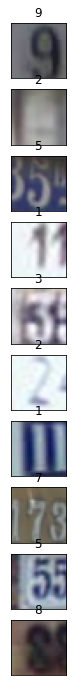

In [15]:
random_inx = np.random.choice(train_x.shape[0], 10)
fig, axes = plt.subplots(10, 1, figsize=(16, 12))

for i, inx in enumerate(random_inx):
    axes[i].set_title(tf_train_y[inx][0].numpy())
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].imshow(train_x[inx])
plt.show()

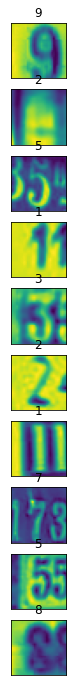

In [16]:
fig, axes = plt.subplots(10, 1, figsize=(16, 12))
for i, inx in enumerate(random_inx):
    axes[i].set_title(tf_train_y[inx][0].numpy())
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].imshow(np.squeeze(tf_train_x[inx]))

    
plt.show()


## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [68]:
def get_dense_model():
    dense_model = Sequential([
                        Flatten(input_shape=tf_train_x[0].shape),
                        Dense(512, activation='relu', kernel_initializer='he_uniform', bias_initializer='ones', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
                        Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
                        Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
                        Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)), 
                        Dense(10, activation='softmax')
                      ])
    return dense_model

In [69]:
dense_model = get_dense_model()
dense_model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
dense_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
Total params: 697,930
Trainable params: 697,930
Non-trainable params: 0
________________________________________________

In [38]:
checkpoint_path ='checkpoint/my_best_model'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
escallback = EarlyStopping(patience=3, monitor='accuracy')

In [39]:
history = dense_model.fit(tf_train_x, tf_train_y, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, escallback], verbose=True)

Epoch 1/30
1832/1832 [==============================] - 10s 6ms/step - loss: 2.4713 - accuracy: 0.2578 - val_loss: 2.0961 - val_accuracy: 0.4105
Epoch 2/30
1832/1832 [==============================] - 10s 6ms/step - loss: 1.8389 - accuracy: 0.5044 - val_loss: 1.6612 - val_accuracy: 0.5815
Epoch 3/30
1832/1832 [==============================] - 9s 5ms/step - loss: 1.5780 - accuracy: 0.6026 - val_loss: 1.5057 - val_accuracy: 0.6293
Epoch 4/30
1832/1832 [==============================] - 9s 5ms/step - loss: 1.4527 - accuracy: 0.6475 - val_loss: 1.4518 - val_accuracy: 0.6443
Epoch 5/30
1832/1832 [==============================] - 10s 5ms/step - loss: 1.3748 - accuracy: 0.6748 - val_loss: 1.4149 - val_accuracy: 0.6544
Epoch 6/30
1832/1832 [==============================] - 10s 5ms/step - loss: 1.3097 - accuracy: 0.6933 - val_loss: 1.3302 - val_accuracy: 0.6854
Epoch 7/30
1832/1832 [==============================] - 9s 5ms/step - loss: 1.2535 - accuracy: 0.7124 - val_loss: 1.3143 - val_accur

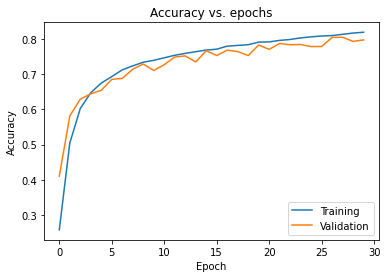

In [41]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

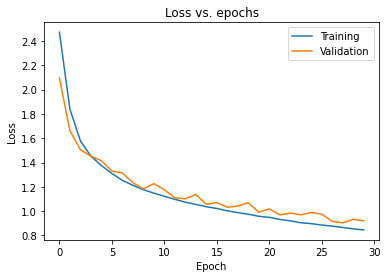

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [43]:
test_loss, test_acc = dense_model.evaluate(tf_test_x, tf_test_y, verbose=False)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

Test loss: 1.0124919414520264
Test accuracy: 0.775468647480011


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [70]:
def get_cnn_model():
    model = Sequential([
                        Conv2D(16, 3, activation='relu', padding='same', name='conv_1',input_shape=tf_train_x[0].shape ),
                        BatchNormalization(),
                        Dropout(0.2),
                        Conv2D(8, 3, activation='relu', padding='same', name='conv_2'),
                        BatchNormalization(),
                        Dropout(0.2),
                        MaxPooling2D(pool_size=(4,4), name='pool_1'),
                        Flatten(name='flatten'),
                        Dense(64, activation='relu', name='dense_1'),
                        Dense(64, activation='relu', name='dense_2'),
                        Dense(10, activation='softmax', name='dense_3')
            ])
    return model
    

In [71]:
model = get_cnn_model()
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 8)         1160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 8, 8, 8)          

In [46]:
checkpoint_path ='cnn_checkpoint/my_best_model'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
escallback = EarlyStopping(patience=3, monitor='accuracy')

In [47]:
history = model.fit(tf_train_x, tf_train_y, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, escallback], verbose=True)

Epoch 1/30
1832/1832 [==============================] - 13s 7ms/step - loss: 2.2094 - accuracy: 0.2204 - val_loss: 1.9955 - val_accuracy: 0.3196
Epoch 2/30
1832/1832 [==============================] - 13s 7ms/step - loss: 1.4304 - accuracy: 0.5318 - val_loss: 1.0988 - val_accuracy: 0.6583
Epoch 3/30
1832/1832 [==============================] - 13s 7ms/step - loss: 0.9099 - accuracy: 0.7167 - val_loss: 0.8224 - val_accuracy: 0.7628
Epoch 4/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.7447 - accuracy: 0.7733 - val_loss: 0.7079 - val_accuracy: 0.7985
Epoch 5/30
1832/1832 [==============================] - 13s 7ms/step - loss: 0.6520 - accuracy: 0.8040 - val_loss: 0.6537 - val_accuracy: 0.8118
Epoch 6/30
1832/1832 [==============================] - 13s 7ms/step - loss: 0.5978 - accuracy: 0.8207 - val_loss: 0.6124 - val_accuracy: 0.8260
Epoch 7/30
1832/1832 [==============================] - 13s 7ms/step - loss: 0.5589 - accuracy: 0.8322 - val_loss: 0.5814 - val_ac

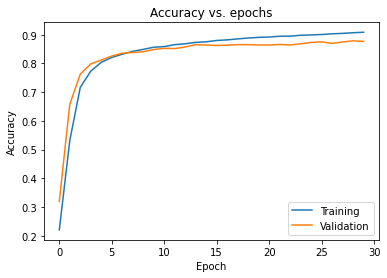

In [51]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

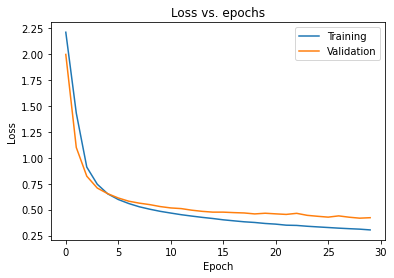

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [53]:
test_loss, test_acc = model.evaluate(tf_test_x, tf_test_y, verbose=False)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

Test loss: 0.4770065248012543
Test accuracy: 0.8596727252006531


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [75]:
# Here best model refers to one with the lowest validation loss
dense_model_inst = get_dense_model()
dense_model_inst.load_weights('checkpoint/my_best_model')
cnn_model_inst = get_cnn_model() 
cnn_model_inst.load_weights('cnn_checkpoint/my_best_model')

In [76]:
test_x_np = np.array(tf_test_x)
test_y_np = np.array(tf_test_y)

num_test_images = test_x_np.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = test_x_np[random_inx, ...]
random_test_labels = test_y_np[random_inx, ...]
print(random_test_images.shape, random_test_labels.shape)

(5, 32, 32, 1) (5, 1)


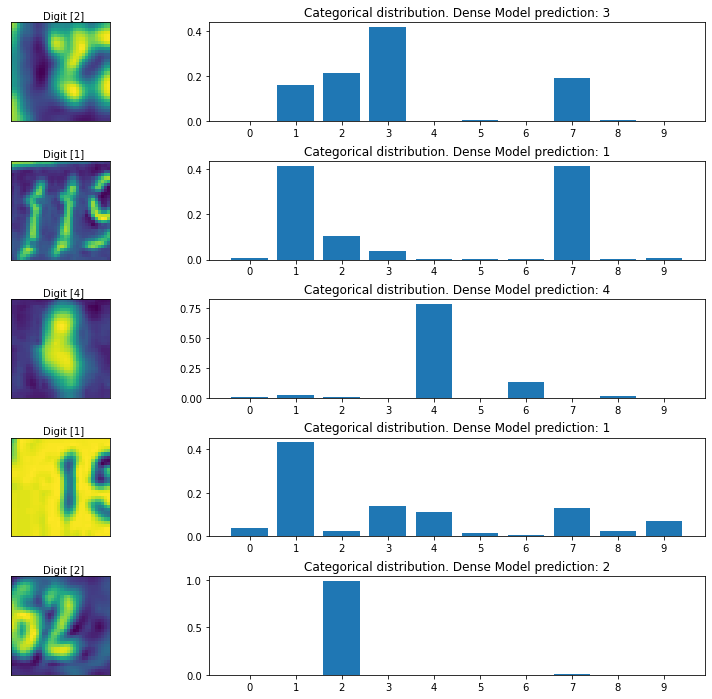

In [80]:
predictions = dense_model_inst.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Dense Model prediction: {np.argmax(prediction)}")
    
plt.show()

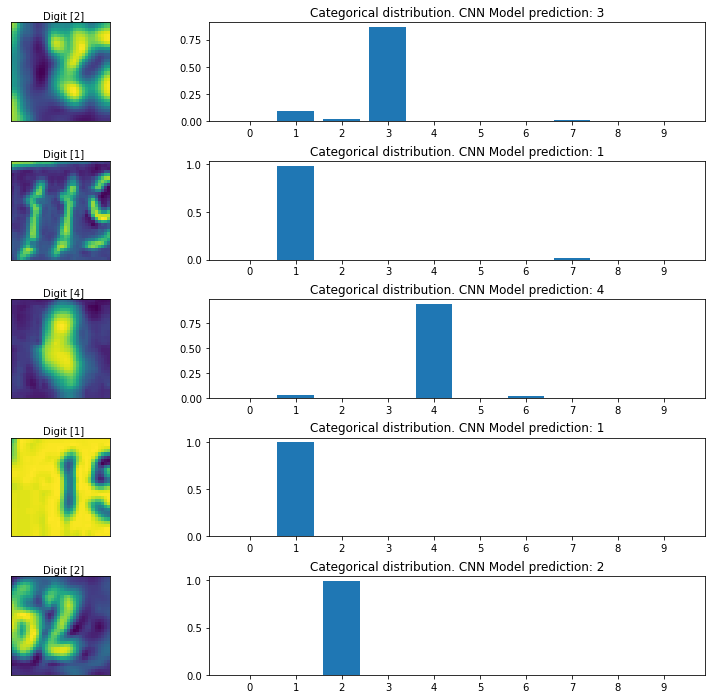

In [81]:
predictions = cnn_model_inst.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. CNN Model prediction: {np.argmax(prediction)}")
    
plt.show()